In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import mne 
warnings.simplefilter(action='ignore', category=FutureWarning)

eeg_file = '/Users/ohadgonen/Desktop/Neuroscience/Year 2/1st semester/Advenced programming in Python/מטלות בית/python_final_project/src/EEG.machinelearing_data_BRMH.csv'  
df = pd.read_csv(eeg_file)

DATA CLEANING AND INITIAL EXPLORATION

In [2]:
# What kind of information are we dealing with? let's get some intuition about the participants.

from src.data_visualization import visualize_non_eeg_data as visualize_non_eeg_data
visualize_non_eeg_data(df)


 Dataset Overview (Categorical Columns Only)
--------------------------------------------------
Categorical Data shape: (945, 8)

Column Names and Data Types:
no.                    int64
sex                   object
age                  float64
eeg.date              object
education            float64
IQ                   float64
main.disorder         object
specific.disorder     object
dtype: object

Missing Values:
no.                   0
sex                   0
age                   0
eeg.date              0
education            15
IQ                   13
main.disorder         0
specific.disorder     0
dtype: int64

Descriptive Statistics:
               no.  sex         age   eeg.date   education          IQ  \
count   945.000000  945  945.000000        945  930.000000  932.000000   
unique         NaN    2         NaN        722         NaN         NaN   
top            NaN    M         NaN  2018.7.17         NaN         NaN   
freq           NaN  601         NaN          5     

In [3]:
# We can see there are some missing values in the education and the IQ columns.
# Since there are 15 and 13 NaNs, numbers which are negligible to the 945 rows, we will fill each of the missing values with the average of the column.
from src.data_cleaning import fill_NaNs as fill_NaNs
cleaned_df = fill_NaNs(df,'education')
cleaned_df = fill_NaNs(df, 'IQ')

In [4]:
# Now let's look at the eeg part of the dataframe.
from src.data_visualization import visualize_eeg_data as visualize_eeg_data
visualize_eeg_data(df)


 Dataset Overview (EEG Columns Only)
--------------------------------------------------
EEG Data shape: (945, 1141)

First 5 rows (electrode columns only):
   AB.A.delta.a.FP1  AB.A.delta.b.FP2  AB.A.delta.c.F7  AB.A.delta.d.F3  \
0         35.998557         21.717375        21.518280        26.825048   
1         13.425118         11.002916        11.942516        15.272216   
2         29.941780         27.544684        17.150159        23.608960   
3         21.496226         21.846832        17.364316        13.833701   
4         37.775667         33.607679        21.865556        21.771413   

   AB.A.delta.e.Fz  AB.A.delta.f.F4  AB.A.delta.g.F8  AB.A.delta.h.T3  \
0        26.611516        25.732649        16.563408        29.891368   
1        14.151570        12.456034         8.436832         9.975238   
2        27.087811        13.541237        16.523963        12.775574   
3        14.100954        13.100939        14.613650         8.063191   
4        22.854536        2

In [5]:
# Check that the df includes no NaNs.
from src.data_cleaning import check_missing_electrode_values as check_missing_electrode_values
check_missing_electrode_values(df)

Missing values in the following electrode columns:
Unnamed: 122    945
dtype: int64


In [6]:
# We've found that column 122 is full of NaNs, hence it doesn't contain any useful data. Let's delete the column.
cleaned_df = cleaned_df.dropna(axis=1, how='all')

In [7]:
# Run check_missing_electrode_values to insure there are no missing values in the dataframe.
check_missing_electrode_values(df)

Missing values in the following electrode columns:
Unnamed: 122    945
dtype: int64


In [ ]:
# Drop all columns that start with 'COH' since they are not relevant to our analysis. We want to work with the raw EEG data. 
cleaned_df = cleaned_df.loc[:, ~cleaned_df.columns.str.startswith('COH')]

In [9]:
# Next, we'll remove any duplicate rows.
cleaned_df = cleaned_df.drop_duplicates()

# Standarize all of the categorical columns in df (by converting all text to lowercase and stripping any leading/trailing spaces).
from src.data_cleaning import standardize_categorical_columns as standardize_categorical_columns
cleaned_df = standardize_categorical_columns(cleaned_df)

# Check for outliers in the categorical columns. 
from src.data_cleaning import check_for_categorical_outliers as check_for_categorical_outliers
check_for_categorical_outliers(cleaned_df)


 No rare categories detected in categorical columns.


In [10]:
# There aren't any categorical outliers in the categorical columns.

In [11]:
# Reformat the electrode columns from prefix.band.type.channel to band.channel.
from src.data_cleaning import reformat_electrode_columns as reformat_electrode_columns
cleaned_df = reformat_electrode_columns(cleaned_df)
cleaned_df.head()

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,delta.FP1,delta.FP2,...,gamma.Cz,gamma.C4,gamma.T4,gamma.T5,gamma.P3,gamma.Pz,gamma.P4,gamma.T6,gamma.O1,gamma.O2
0,1,m,57.0,2012.8.30,13.43871,101.580472,addictive disorder,alcohol use disorder,35.998557,21.717375,...,1.993727,1.765493,1.464281,1.501948,1.707307,1.553448,1.552658,1.388662,1.592717,1.806598
1,2,m,37.0,2012.9.6,6.00000,120.000000,addictive disorder,alcohol use disorder,13.425118,11.002916,...,0.903383,0.931967,0.437117,0.930843,1.234874,1.373268,1.411808,1.140695,1.118041,3.162143
2,3,m,32.0,2012.9.10,16.00000,113.000000,addictive disorder,alcohol use disorder,29.941780,27.544684,...,1.096713,1.691152,1.505663,1.133891,1.661768,1.403429,1.349457,1.270525,1.408471,1.454618
3,4,m,35.0,2012.10.8,18.00000,126.000000,addictive disorder,alcohol use disorder,21.496226,21.846832,...,1.115040,1.122776,2.128138,1.648217,1.147666,1.049152,1.131654,1.415856,1.391048,1.527403
4,5,m,36.0,2012.10.18,16.00000,112.000000,addictive disorder,alcohol use disorder,37.775667,33.607679,...,1.193191,2.320845,3.562820,1.441662,1.018804,1.274009,2.350806,2.307730,2.129431,3.766860


In [12]:
# We will leave all of the values in the eeg data columns because we don't wish to modify it.

In [13]:
# Update the original dataframe, after the cleaning.
df = cleaned_df

DATA ANALYSIS

Q1: What is the characteristic EEG activity of different main psychiatric disorders?

['addictive disorder' 'trauma and stress related disorder' 'mood disorder'
 'healthy control' 'obsessive compulsive disorder' 'schizophrenia'
 'anxiety disorder']


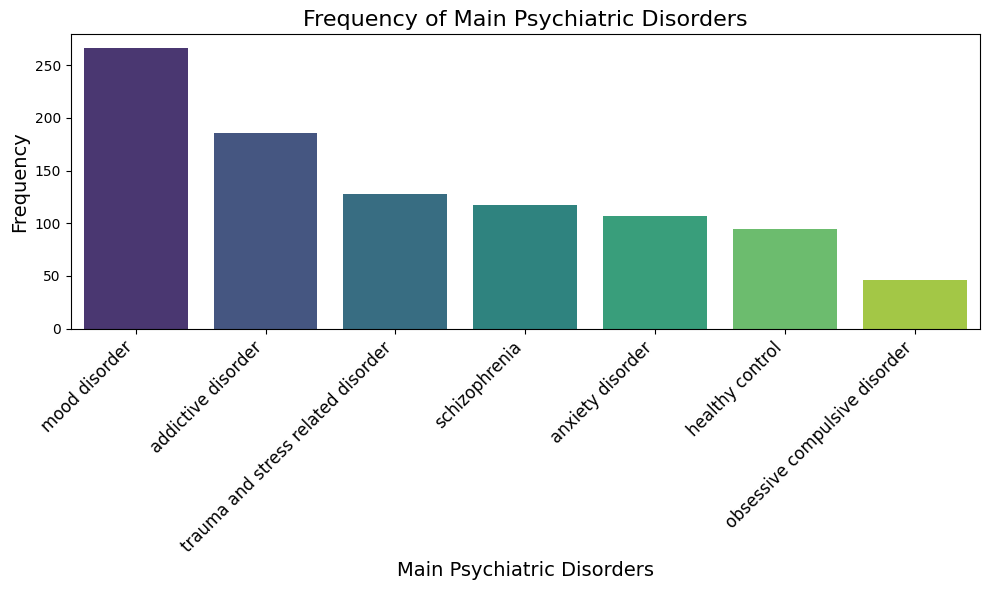

In [14]:
# Let's start by checking the distribution of the main psychiatric disorder column.
from src.data_visualization import visualize_main_psychiatric_disorders as visualize_main_psychiatric_disorders
print(df['main.disorder'].unique())
visualize_main_psychiatric_disorders(df)

In [15]:
from src.data_analysis import calculate_band_averages as calculate_band_averages
# Choose an example main disorder.
main_disorder = "schizophrenia"
# Create a dictionary of average electrode activity in each band for schizophrenia. 
band_averages = calculate_band_averages(main_disorder, df)
# Display the result dictionary's keys
band_averages.keys()

dict_keys(['delta', 'theta', 'alpha', 'beta', 'gamma', 'highbeta'])

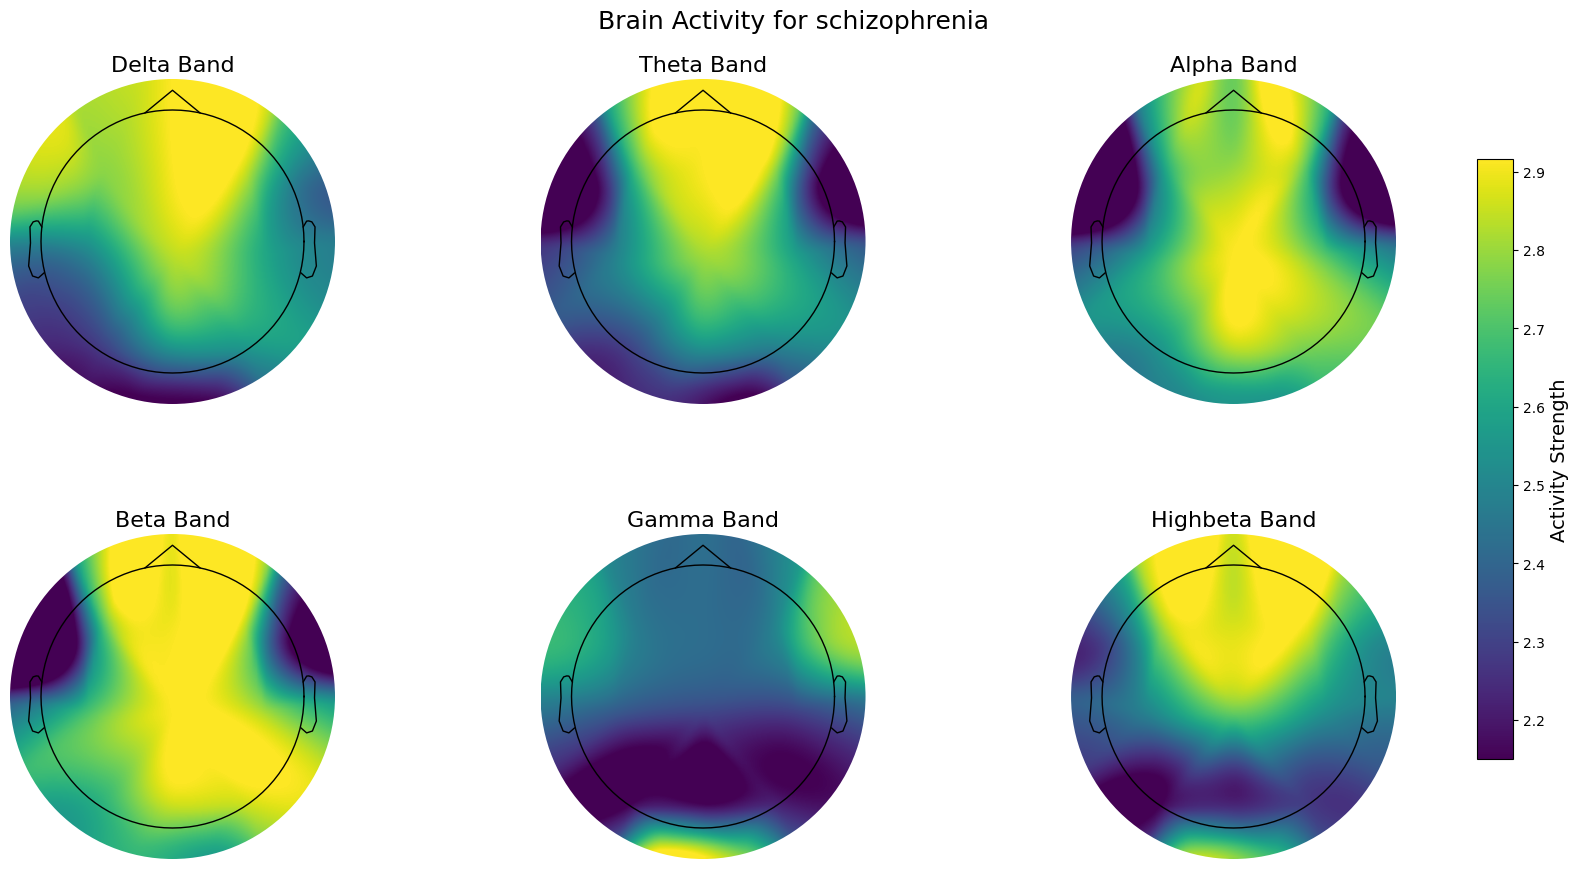

In [16]:
from src.data_visualization import visualize_brain_activity as visualize_brain_activity
# Visualize the brain activity for the given band averages in schizophrenia.
visualize_brain_activity(band_averages, main_disorder)

In [17]:
# We will try to look for significant differences in the brain activity of main.disorder vs healthy control. 
# We will take schizophrenia as a first example. 
from src.data_analysis import find_significant_differences as find_significant_differences

hc = "healthy control"
main_disorder = "schizophrenia"
# Create a dictionary of average electrode activity in each band for healthy control. 
healthy_band_averages = calculate_band_averages(hc, df)
# Create a dictionary of average electrode activity in each band for schizophrenia.
disorder_band_averages = calculate_band_averages(main_disorder, df)

significant_differences = find_significant_differences(df, main_disorder, hc,  p_threshold=0.0001, activity_type= "enhanced")
print(significant_differences)

{'delta': ['O1', 'O2'], 'theta': [], 'alpha': [], 'beta': ['FP1', 'FP2', 'Fz', 'F4', 'F8', 'C4', 'O1'], 'gamma': [], 'highbeta': []}


This statistical analysis confirms that individuals with schizophrenia exhibit heightened delta activity (0.5–4 Hz) in the occipital lobe (O1, O2), a region crucial for visual processing.

Given that delta waves are typically associated with deep sleep and unconscious states, their increased presence in the visual cortex suggests a dream-like neural state while awake, potentially contributing to visual hallucinations. This aligns with the idea that hallucinations in schizophrenia may arise from the brain’s inability to properly distinguish between internally generated and externally perceived stimuli.

Additionally, elevated beta activity (12–30 Hz) in frontal and central regions (FP1, FP2, Fz, F4, F8, C4) points to increased but dysregulated cognitive processing, which may contribute to thought disorder and executive dysfunction—key symptoms of schizophrenia.

Notably, there were no significant changes in theta (4–8 Hz), alpha (8–12 Hz), gamma (30–100 Hz), or high-beta (20–35 Hz) activity, indicating that schizophrenia is not characterized by a general increase in neural excitation but rather by specific disruptions in certain frequency bands.

The lack of gamma enhancement is particularly interesting, as gamma waves are crucial for conscious perception and sensory integration—their absence may reflect fragmented neural synchrony, leading to perceptual distortions and cognitive disorganization. These findings support the hypothesis that schizophrenia involves aberrant thalamo-cortical communication and disrupted sensory gating mechanisms.

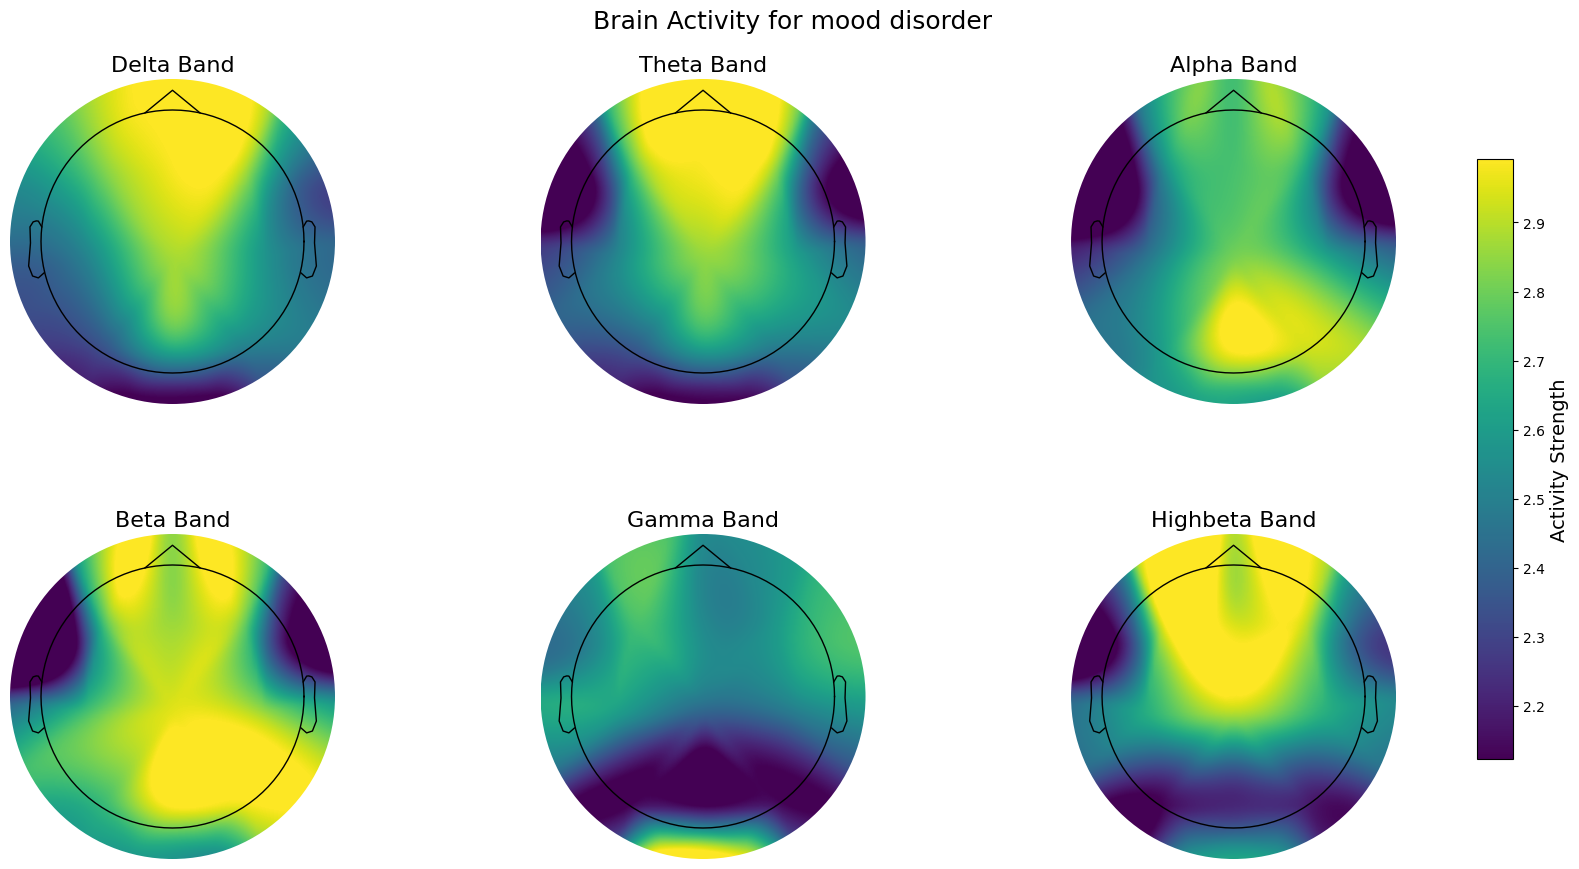

{'delta': ['P4', 'O1', 'O2'], 'theta': ['O2'], 'alpha': [], 'beta': ['FP1', 'FP2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'C3', 'Cz', 'C4', 'P3', 'Pz', 'P4', 'O1', 'O2'], 'gamma': ['P3'], 'highbeta': ['F3', 'C3', 'Cz', 'C4', 'P3', 'Pz', 'P4', 'O1']}


In [18]:
# Let's try to examine another disorder.
main_disorder = "mood disorder"
# Create a dictionary of average electrode activity in each band for mood disorder. 
band_averages = calculate_band_averages(main_disorder, df)
# Visualize the brain activity for the given band averages in mood disorder.
visualize_brain_activity(band_averages, main_disorder)

# Find significant enhanced activity in mood disorder compared to healthy control. 
disorder_band_averages = calculate_band_averages(main_disorder, df)
significant_differences = find_significant_differences(df, main_disorder, hc,  p_threshold=0.01, activity_type= "enhanced")
print(significant_differences)

These findings suggest that individuals with mood disorders exhibit significantly increased beta and high-beta activity across multiple brain regions compared to healthy controls.

Beta Waves (12–30 Hz) and High-Beta (25-30 Hz) waves are typically associated with active thinking, problem-solving, and alertness. Excessive beta activity can correlate with anxiety, stress, and hyperarousal, which are often observed in mood disorders like major depressive disorder and bipolar disorder.

In [19]:
# Let's search for areas and frequency bands with reduced activity in mood disorder.
significant_differences = find_significant_differences(df, main_disorder, hc,  p_threshold=0.05, activity_type ="lower")
print(significant_differences)

{}


We can't detect any significant reduced activity in mood disorder.

In [20]:
# Try addictive disorder as an example for reduced activity. 
main_disorder = "addictive disorder"
# p = 0.28 is the lowest value we have found that gives us an electrode with reduced activity. 
significant_differences = find_significant_differences(df, main_disorder, hc,  p_threshold=0.28, activity_type ="lower")
print(significant_differences)

{'delta': [], 'theta': [], 'alpha': [], 'beta': [], 'gamma': ['C3'], 'highbeta': []}


In fact, we couldn't really find any significant reduced activity in any of the disorders compared to healthy controls. 

We have several hypotheses for why this is the case:

1. 	Disinhibition and Neural Hyperactivity: Many psychiatric disorders involve impaired inhibitory control (e.g., GABAergic dysfunction), leading to excessive neural firing and increased EEG power rather than reductions.

2. 	Compensatory Mechanisms: The brain may increase neural activity in certain regions to compensate for deficits in others, maintaining cognitive function despite dysfunction.

3. Hyperconnectivity and Dysregulated Networks: Instead of simple underactivity, psychiatric disorders might involve overactive or dysregulated neural networks, causing increased EEG power, especially in certain frequency bands (e.g., theta, beta).

4. Medication and Physiological Factors: Many psychiatric medications (e.g., antipsychotics, SSRIs, stimulants) can increase EEG activity in specific bands, possibly contributing to the observed enhancements.

In [21]:
# Visualize the EEG head maps for all disorders. 

from src.data_analysis import prepare_disorder_band_averages as prepare_disorder_band_averages
# Prepare the required arguments for the `visualize_all_disorders` function from the given dataset.
disorders = df['main.disorder'].unique().tolist()
frequency_bands = ["delta", "theta", "alpha", "beta", "gamma", "highbeta"]
electrodes = ['FP1', 'FP2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'C3', 'Cz', 'C4', 'T8', 
              'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'O2']

# Generate the required arguments
disorder_band_averages, disorder_names = prepare_disorder_band_averages(df, disorders, frequency_bands, electrodes)

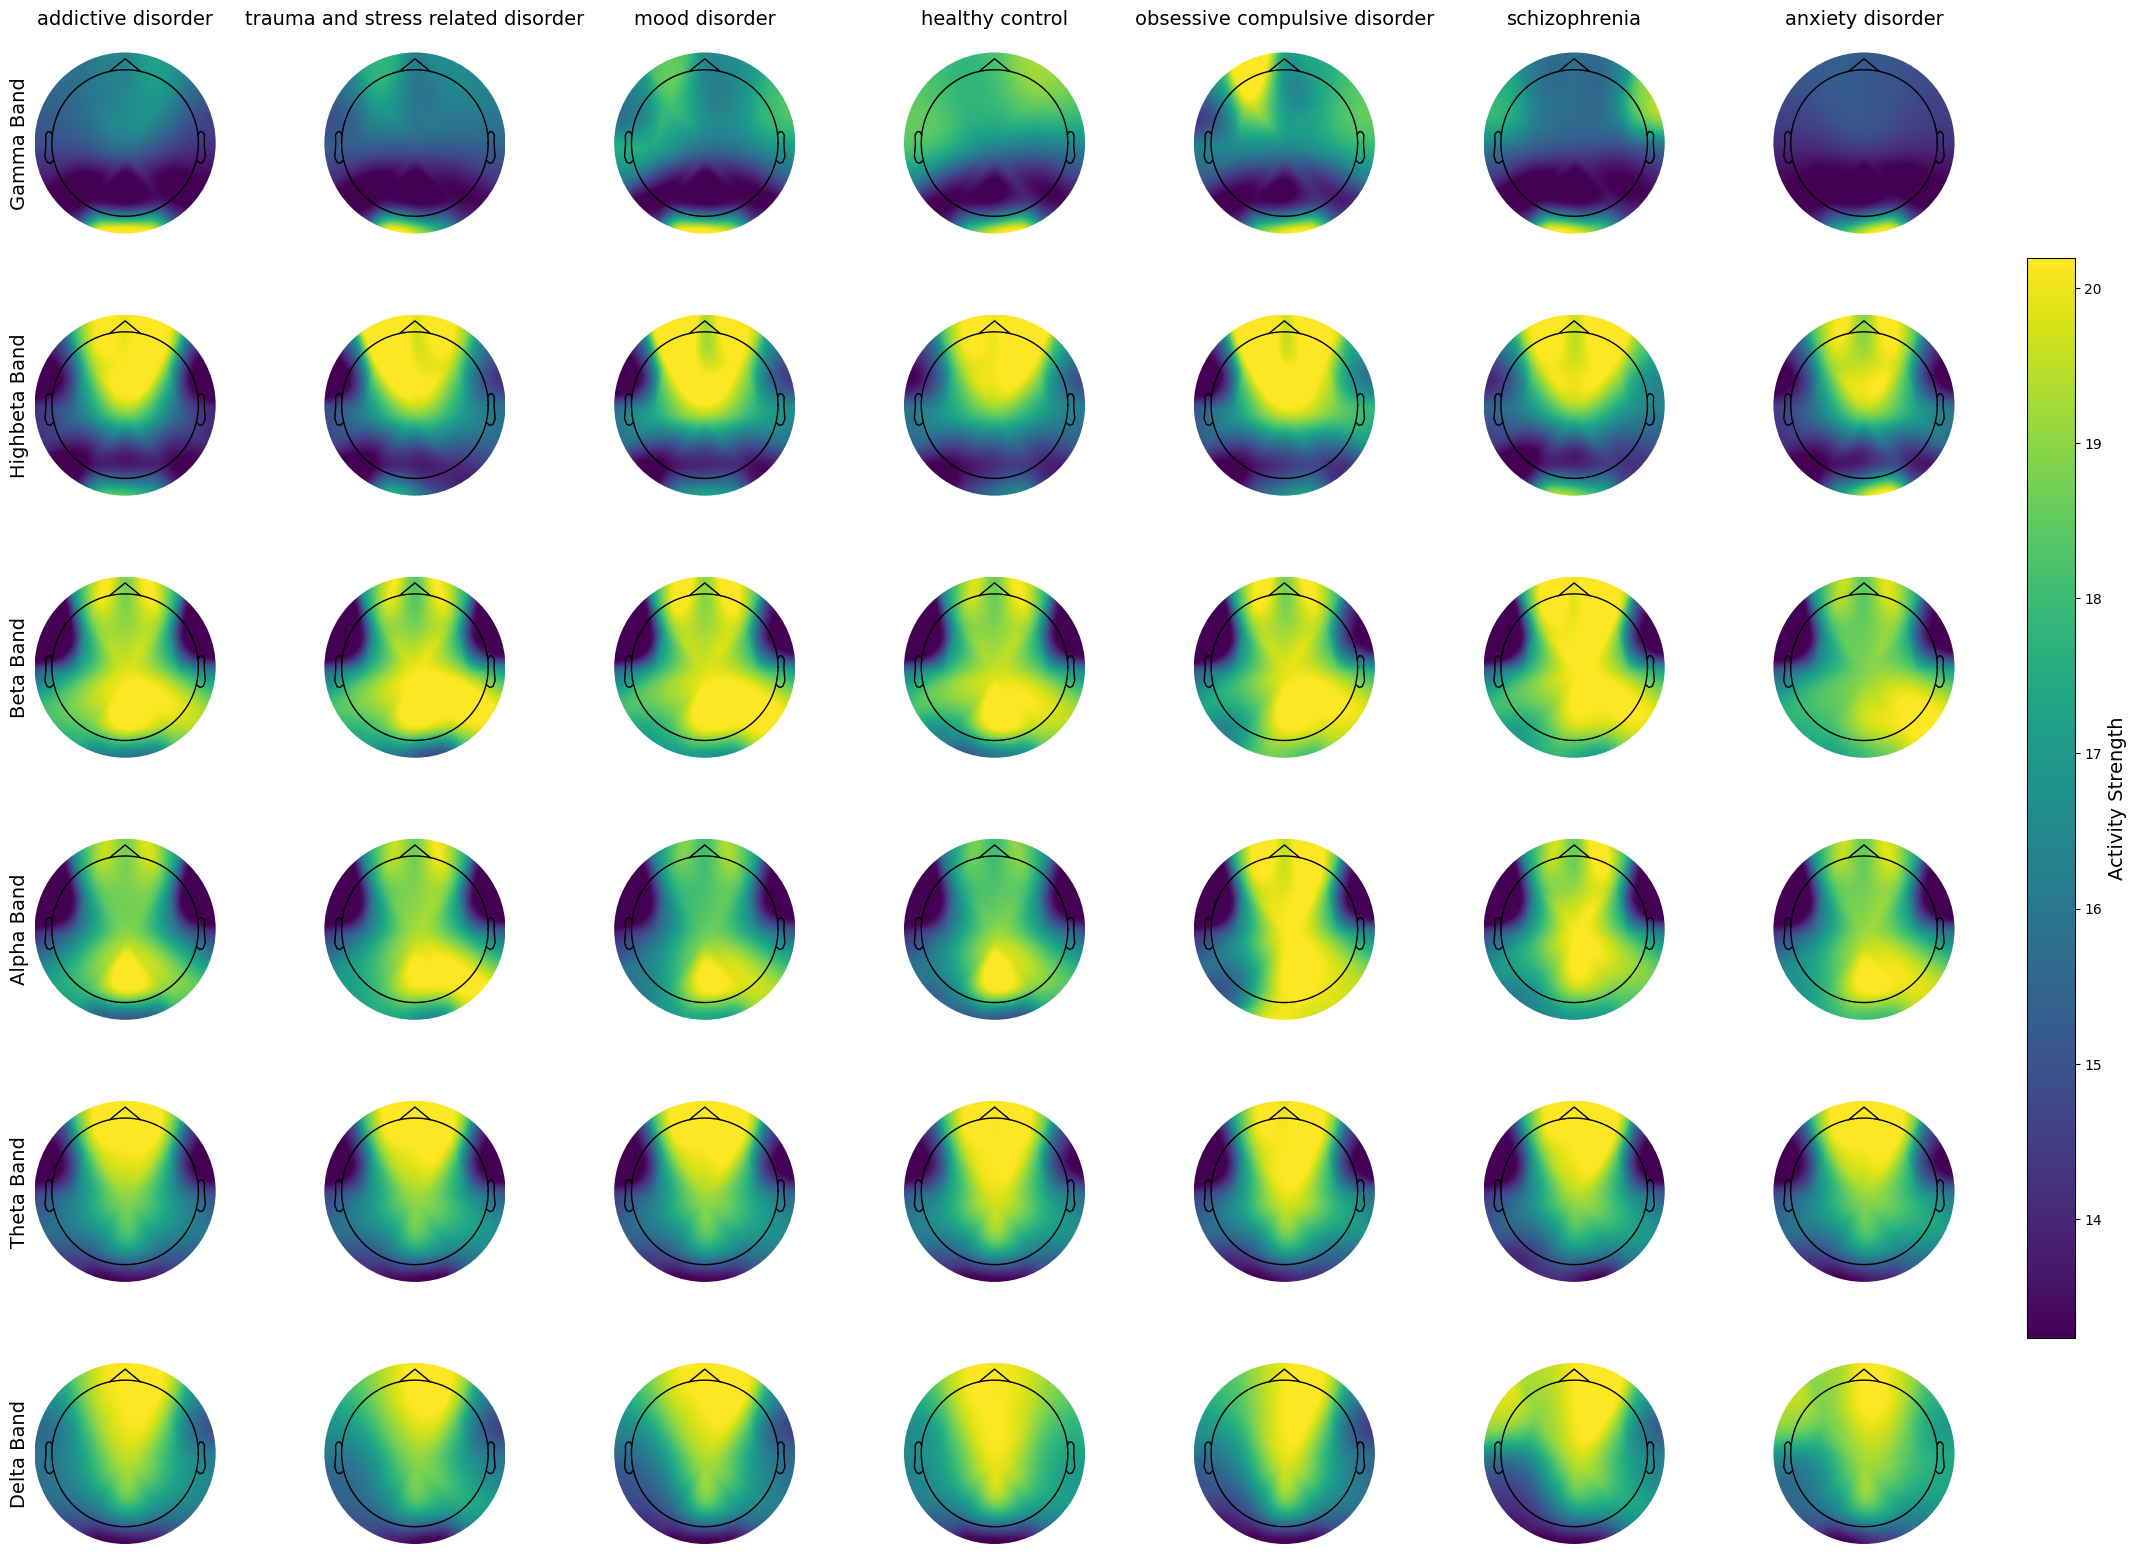

In [22]:
# Visualize the brain activity for all main disorders in the dataset.
from src.data_visualization import visualize_all_disorders as visualize_all_disorders

visualize_all_disorders(disorder_band_averages, disorder_names)

# The strength of of the EEG activity is normalized compared to the minimun and maximun values of the band averages. 

Q2: How do different specific disorders vary in brain activity across various frequency bands within the same main disorder?

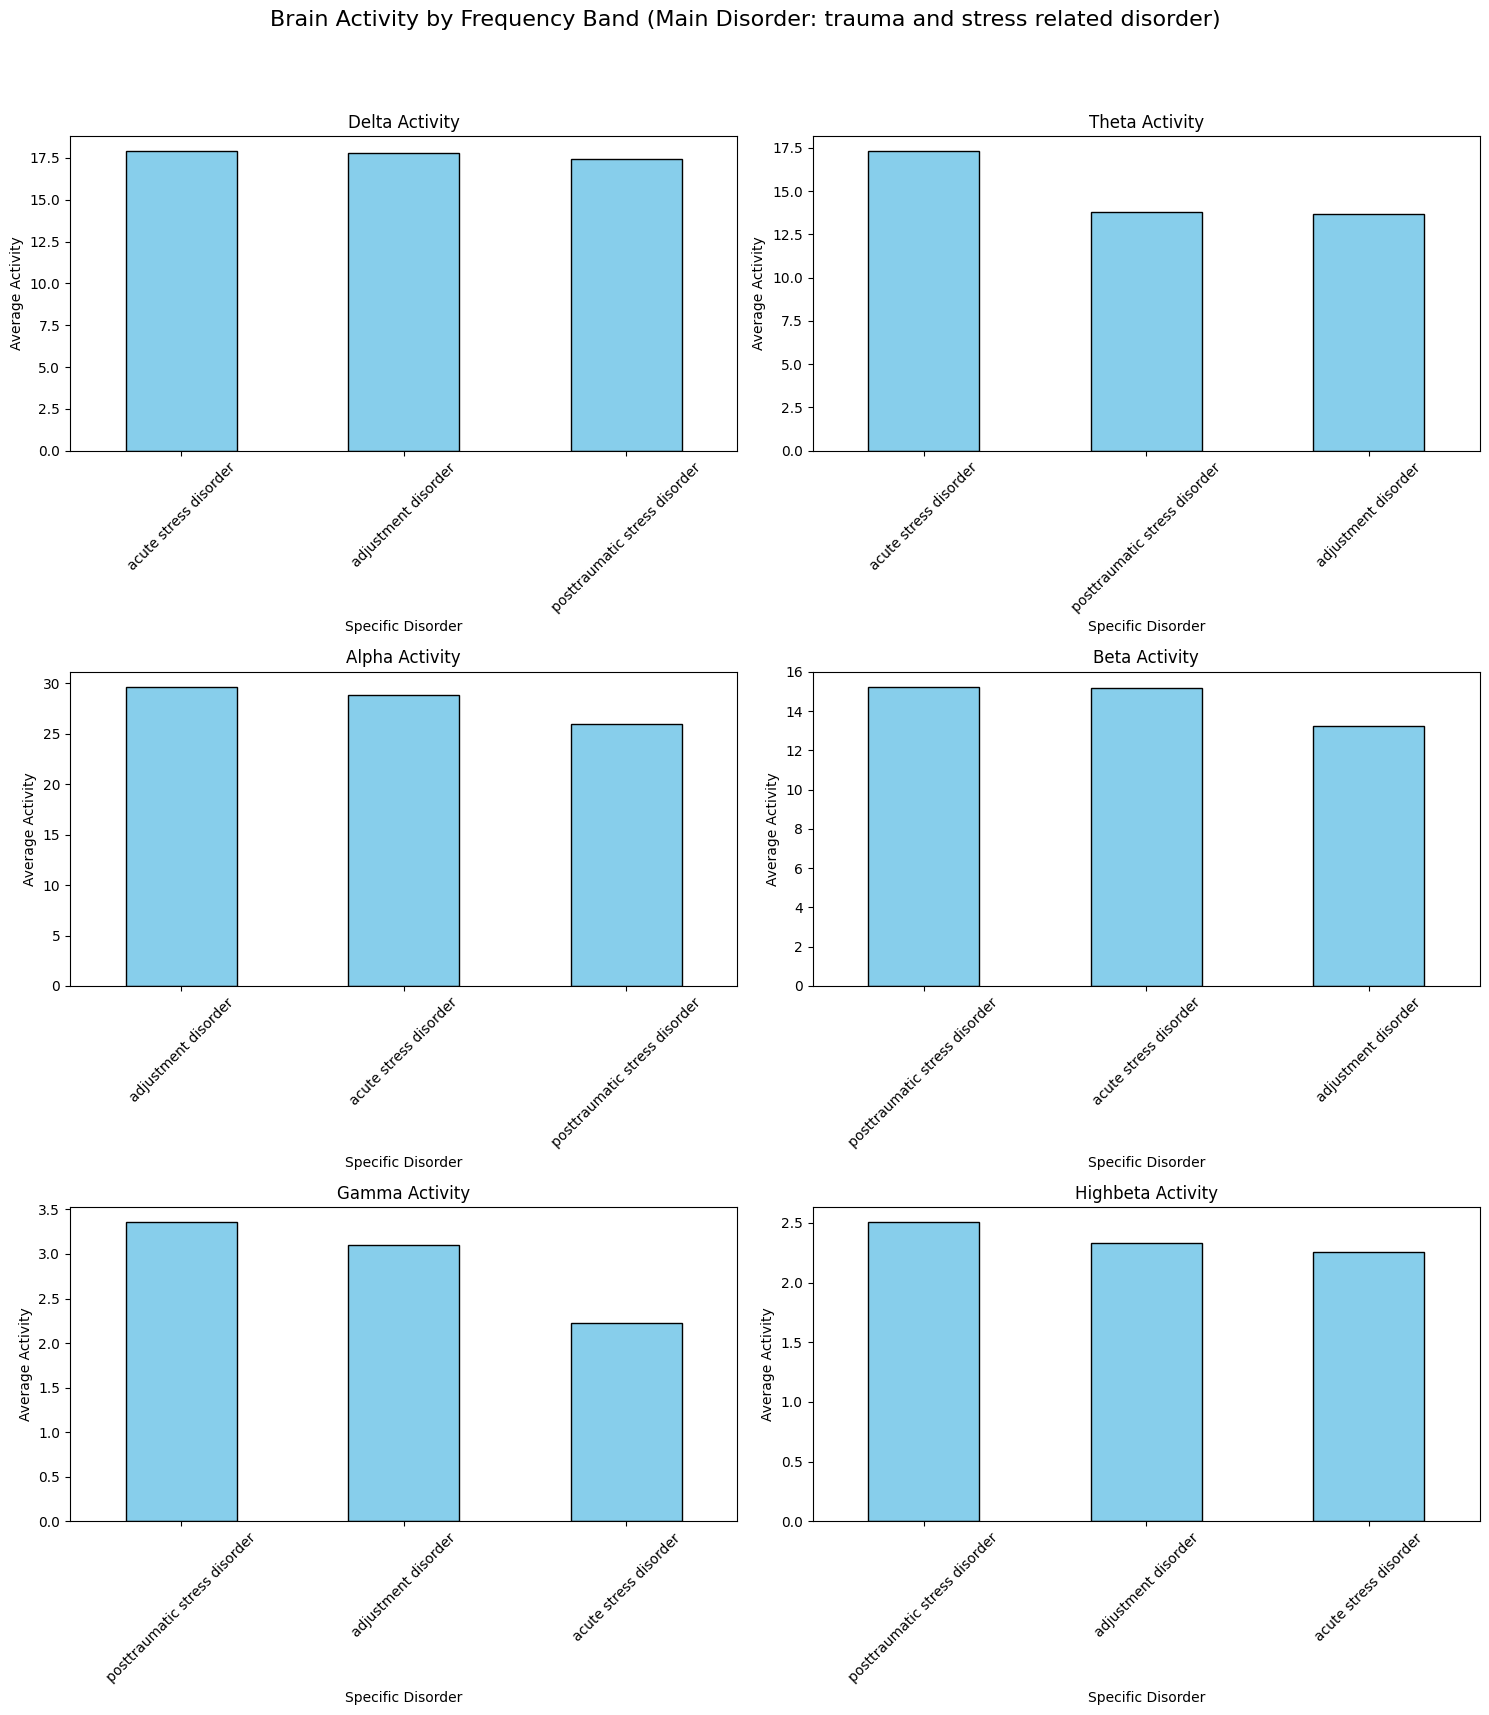

In [23]:
from src.data_visualization import plot_brain_activity_by_disorder
main_disorder = "trauma and stress related disorder"
plot_brain_activity_by_disorder(df,main_disorder)

Posttraumatic stress disorder (PTSD) shows the highest gamma activity, indicating heightened cognitive engagement or stress responses compared to other disorders.

Adjustment disorder exhibits the highest alpha activity, suggesting relatively better relaxation or focus among the disorders.

Acute stress disorder displays consistently high delta and theta activity, reflecting its association with stress and baseline brain processing.

Highbeta activity shows minimal variation across disorders, indicating that it may not be as sensitive to differences within this category.

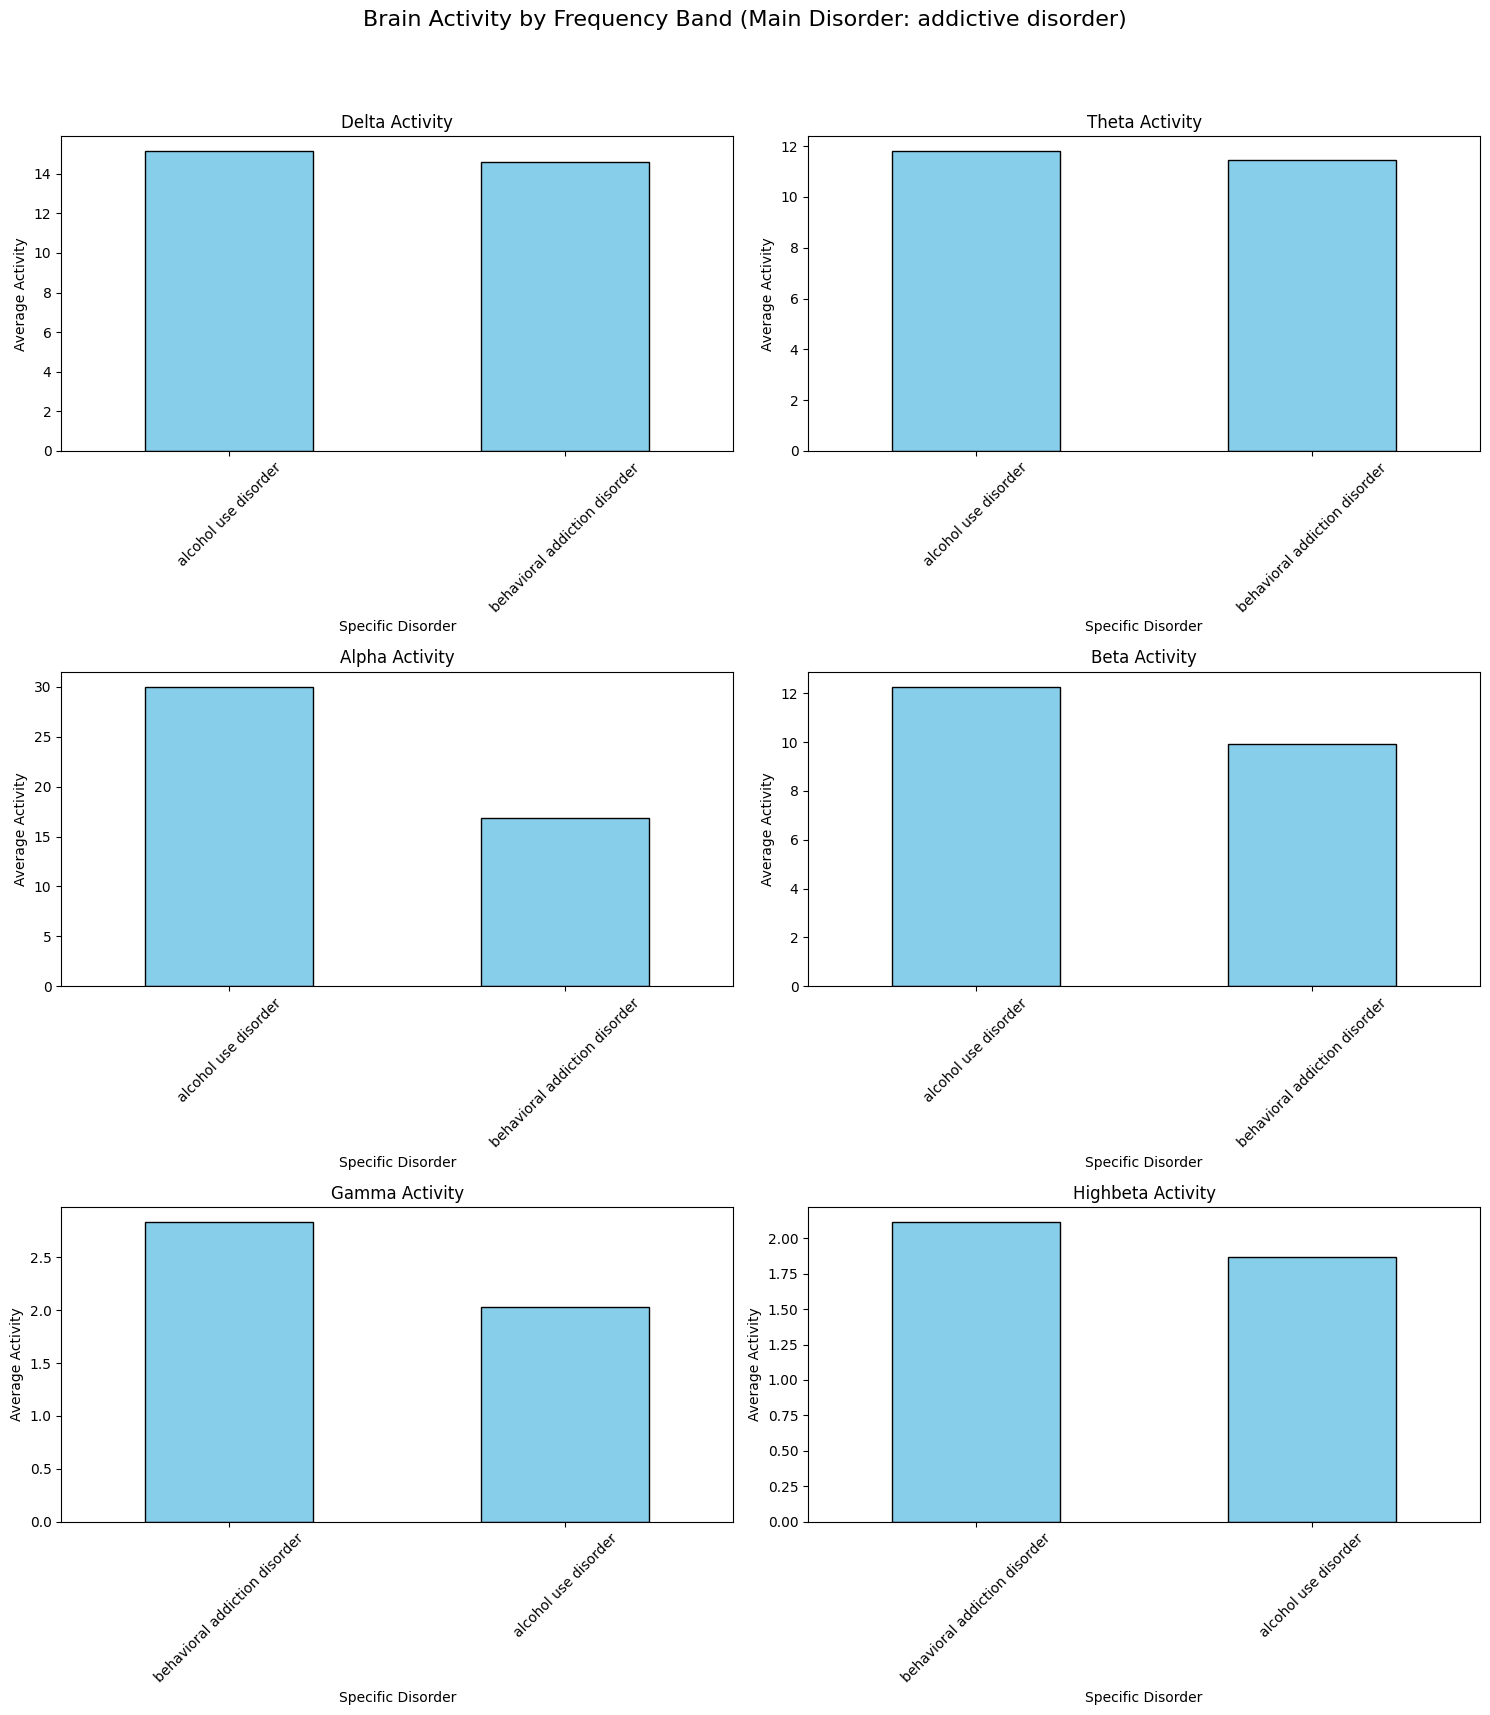

In [24]:
main_disorder = "addictive disorder"
plot_brain_activity_by_disorder(df,main_disorder)

Alcohol use disorder shows higher alpha (8-12 Hz) activity compared to behavioral addiction disorder, indicating a greater tendency for relaxation or mental disengagement.

Behavioral addiction disorder has higher gamma activity, suggesting greater cognitive engagement than alcohol use disorder.

Delta and theta activity are relatively similar between the two disorders, indicating comparable baseline brain processing for these lower frequency bands.

Q3: Are there any strong correlations between distant (not adjacent) electrodes in healthy controls? 

In [25]:
# We defined distant electrodes as pairs of electrodes located in different brain regions that are anatomically and functionally separated.
# Specifically, we consider electrodes distant if they belong to one of the following region pairs:
# Frontal–Occipital, Frontal–Temporal, Central–Occipital, Temporal–Parietal, or Temporal–Occipital. 
# This ensures that only true long-range correlations are analyzed, excluding nearby or highly connected regions.

# What are the strongest correlations between distant electrodes in healthy controls?
from src.data_analysis import find_strong_long_range_correlations as find_strong_long_range_correlations

# Create a df that contains only healthy controls. 
disorder = "healthy control"
hc_df = df[df['main.disorder'] == disorder]

# Run the function to find the top 45 strongest long-range correlations.
top_long_range_corr_df = find_strong_long_range_correlations(hc_df, num_pairs=45, threshold=0.6)

# Display the resulting DataFrame.
top_long_range_corr_df.head()

,Feature 1,Feature 2,Correlation
423,alpha.P4,alpha.T6,0.946346
432,alpha.T6,alpha.P4,0.946346
737,gamma.P3,gamma.T5,0.929227
726,gamma.T5,gamma.P3,0.929227
371,alpha.F4,alpha.T4,0.909644


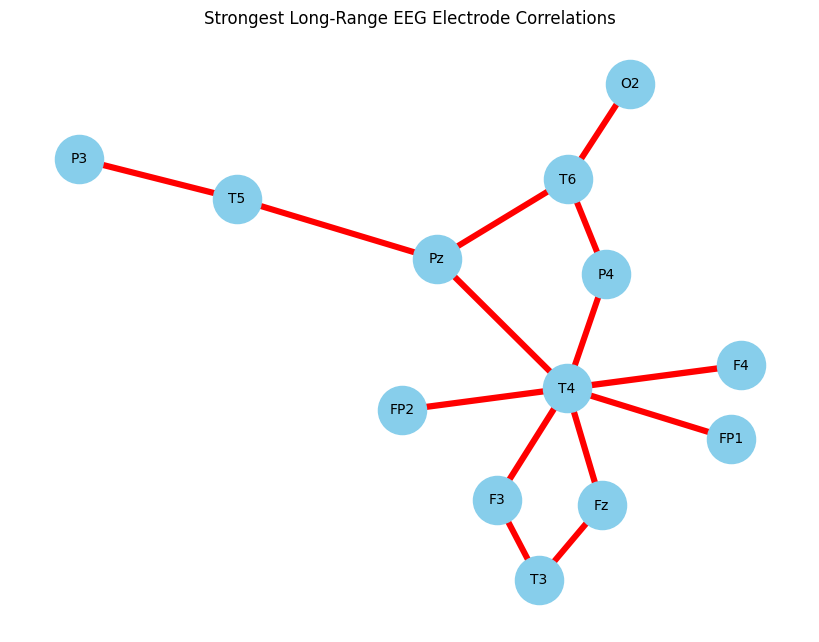

In [26]:
# Visualize the long-range correlations. 
from src.data_visualization import visualize_long_range_correlations as visualize_long_range_correlations
visualize_long_range_correlations(top_long_range_corr_df)

During rest, the brain exhibits spontaneous activity that forms distinct networks, such as the default mode network (DMN), visual network, and sensorimotor network. The observed distant correlations could represent intrinsic connectivity between regions associated with these networks.

This EEG correlation network highlights strong long-range connections, with T4 acting as a central hub linking frontal, parietal, temporal, and occipital regions. The T4-Pz-P4-T6-O2 pathway suggests multimodal sensory integration, likely involving auditory and visual processing.

Strong frontal-temporal links (Fz-T3-T4-F3) indicate interactions between executive functions and memory-related processes, while frontal-occipital connections (FP1, FP2, F4-O2) suggest top-down modulation of sensory perception.


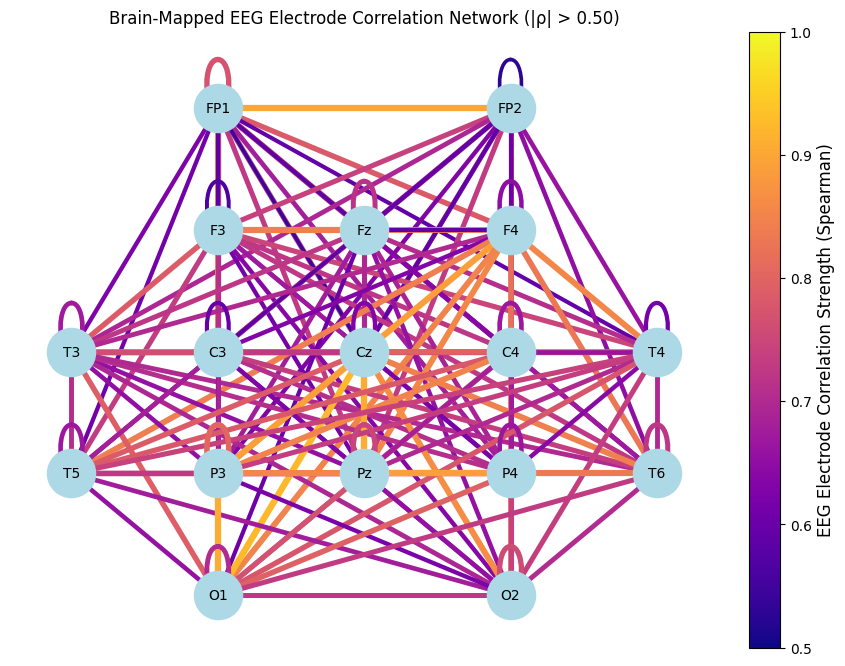

In [27]:
# Let's try to map all of the strong correlations (>0.5) between all electrodes of healthy controls patients. 
from src.data_visualization import visualize_correlation_gradient as visualize_correlation_gradient
visualize_correlation_gradient(hc_df)

The EEG electrode correlation network for healthy controls reveals widespread functional connectivity, with strong correlations particularly in the frontal (FP1, FP2, F3, F4) and central (Cz, Fz, C3, C4) regions, suggesting robust frontal-central integration, often associated with executive function and attentional control.


Temporal electrodes (T3, T4, T5, T6) display strong interconnections, reflecting coordinated activity likely related to auditory and language processing, while occipital sites (O1, O2) show integration with other regions, indicative of visual processing networks.

The network exhibits a high density of strong correlations, pointing to globally synchronized activity across hemispheres, a hallmark of stable and efficient neural communication in a healthy resting-state brain.

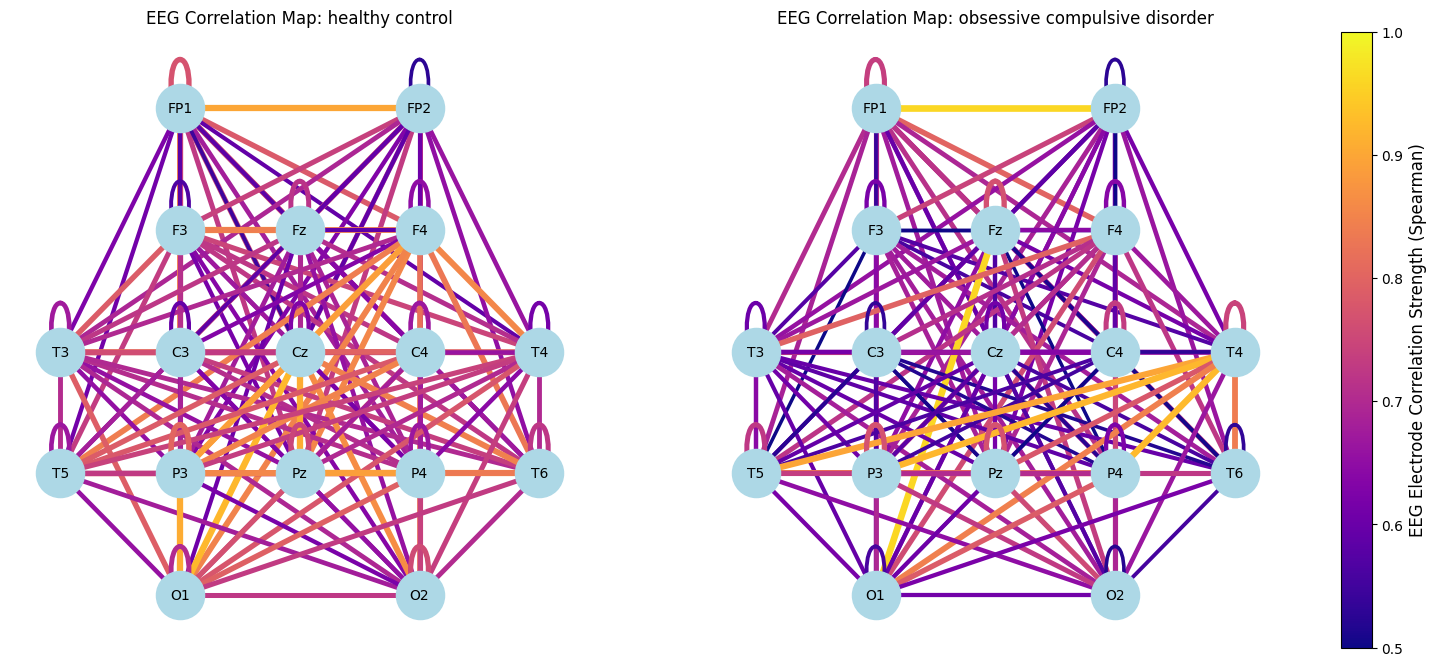

In [28]:
# How do correlation patterns differ between healthy controls and patients with OCD?
# We can use our correlation measure to compare these two groups. 
from src.data_visualization import visualize_correlation_gradient_by_disorders as visualize_correlation_gradient_by_disorders
visualize_correlation_gradient_by_disorders(df,'healthy control', 'obsessive compulsive disorder')

The healthy brain exhibits a balanced and distributed network, with strong frontal-central integration and well-connected temporal-occipital regions, supporting efficient sensory and cognitive processing.

In contrast, the OCD network shows increased local connectivity, particularly in posterior-temporal regions (Pz, T5, T6, O1, O2), and weaker uniform frontal-central integration, suggesting hyperactive sensory processing and altered executive control. 

These differences align with known hyperconnectivity in OCD, potentially contributing to compulsive behaviors and rigid thought patterns.

Q4: Can we predict the main psychiatric disorder based on the EEG data?

In [29]:
from src.model import split_data, train_model, evaluate_model, preprocess_data

# Running the pipeline
df_processed, label_encoders = preprocess_data(df)
X_train, X_test, y_train, y_test = split_data(df_processed)
rf_model = train_model(X_train, y_train)
accuracy, classification_rep = evaluate_model(rf_model, X_test, y_test, label_encoders["main.disorder"])

# Convert classification report dictionary to a DataFrame
classification_df = pd.DataFrame.from_dict(classification_rep).transpose()

# Print accuracy and classification report as a formatted table
print(f"\nModel Accuracy: {accuracy:.2f}\n")
print("Classification Report:")
print(classification_df.to_string()) 

# We have achieved an accuracy of 0.34, which is not very high. 


Model Accuracy: 0.34

Classification Report:
                                    precision    recall  f1-score     support
addictive disorder                   0.382353  0.382353  0.382353   34.000000
anxiety disorder                     0.666667  0.125000  0.210526   16.000000
healthy control                      0.750000  0.157895  0.260870   19.000000
mood disorder                        0.325758  0.767857  0.457447   56.000000
obsessive compulsive disorder        0.000000  0.000000  0.000000    9.000000
schizophrenia                        0.125000  0.050000  0.071429   20.000000
trauma and stress related disorder   0.428571  0.085714  0.142857   35.000000
accuracy                             0.343915  0.343915  0.343915    0.343915
macro avg                            0.382621  0.224117  0.217926  189.000000
weighted avg                         0.389731  0.343915  0.282384  189.000000


The model has high precision (0.75) but very low recall (0.16) for healthy controls, meaning it correctly identifies them when predicted but misses most actual cases. 

Mood disorders show high recall (0.77) but low precision (0.33), indicating the model frequently misclassifies other disorders as mood disorders. 

Anxiety disorders have high precision (0.67) but low recall (0.13), suggesting the model avoids false positives but fails to detect many actual cases. 

Schizophrenia and OCD perform very poorly (F1-scores of 0.07 and 0.00, respectively), showing that the model struggles to identify these disorders at all.

The overall accuracy is 34%, indicating significant room for improvement, especially in recall for underrepresented disorders.